In [1]:
label_path = r"/kaggle/input/expression-in-the-wild-expw-dataset/label.lst"
images_path=r"/kaggle/input/origin-expw/origin"

In [2]:
import pandas as pd

face_data = pd.read_csv(label_path, sep=" " , header= None)
face_data

,0,1,2,3,4,5,6,7
0,angry_actor_104.jpg,0,28,113,226,141,22.9362,0
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,0
2,angry_actor_120.jpg,1,53,53,372,372,13.9434,2
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,3
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,0
...,...,...,...,...,...,...,...,...
91788,surprised_expression_546.jpg,0,70,70,351,351,37.7117,5
91789,surprised_expression_381.jpg,0,51,61,117,107,91.6307,5
91790,surprised_expression_395.jpg,0,27,95,258,190,96.2861,5
91791,ecstatic_asian_31.jpg,0,60,136,184,108,39.9223,3


In [3]:
face_data.columns =['image_name', 'face_id_in_image', 'face_box_top', 'face_box_left' , 'face_box_right' , 'face_box_bottom' , 'face_box_cofidence' , 'expression_label']
face_data

,image_name,face_id_in_image,face_box_top,face_box_left,face_box_right,face_box_bottom,face_box_cofidence,expression_label
0,angry_actor_104.jpg,0,28,113,226,141,22.9362,0
1,angry_actor_109.jpg,0,31,157,345,219,50.3056,0
2,angry_actor_120.jpg,1,53,53,372,372,13.9434,2
3,angry_actor_13.jpg,0,77,51,362,388,85.8104,3
4,angry_actor_132.jpg,0,95,31,412,476,82.3948,0
...,...,...,...,...,...,...,...,...
91788,surprised_expression_546.jpg,0,70,70,351,351,37.7117,5
91789,surprised_expression_381.jpg,0,51,61,117,107,91.6307,5
91790,surprised_expression_395.jpg,0,27,95,258,190,96.2861,5
91791,ecstatic_asian_31.jpg,0,60,136,184,108,39.9223,3


In [4]:
face_data.shape

(91793, 8)

In [5]:
face_cofidence = face_data[face_data.face_box_cofidence > 55]

In [6]:
face_cofidence.shape

(39599, 8)

In [7]:
from numpy.core.fromnumeric import resize
import cv2
import matplotlib.pyplot as plt
import os


stored_image = []
stored_label = []

for i, row in face_cofidence.sample(10000).iterrows():
    image_name = row["image_name"]
    left = row["face_box_left"]
    right = row["face_box_right"]
    top = row["face_box_top"]
    bottom = row["face_box_bottom"]
    label = row["expression_label"]
    img_path = os.path.join(images_path, image_name)
    read_image = cv2.imread(img_path)

    if read_image is not None:
         crop_image = read_image[top:bottom , left:right]
    else:
        continue

    if crop_image  is not None:
     crop_resize = cv2.resize(crop_image  , ( 64,64))

    else:
      continue

    stored_image.append(crop_resize)
    stored_label.append(label)



In [8]:

import numpy as np

X = np.array(stored_image)
Y = np.array(stored_label)

In [9]:
x = X / 255.0

In [10]:
X_shaped = x.reshape((-1,64*64*3))
X_shaped.shape

(10000, 12288)

In [11]:
import pandas as pd
pd.Series(Y).value_counts()

3    3884
6    3190
4     938
5     906
0     493
1     473
2     116
Name: count, dtype: int64

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_smote,Y_smote = smote.fit_resample(X_shaped, Y)

In [13]:
pd.Series(Y_smote).value_counts()

3    3884
6    3884
4    3884
5    3884
0    3884
1    3884
2    3884
Name: count, dtype: int64

In [14]:
x = X_smote.reshape(-1,64,64,3)

In [15]:
Y = Y_smote

In [16]:
len(x)


27188

In [17]:
len(X)


10000

In [18]:
import numpy as np

from keras.utils import to_categorical
y = to_categorical(Y)

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)


In [20]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import ImageDataGenerator


img_datagen = ImageDataGenerator(

    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


img_datagen.fit(X_train)

In [23]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
num_classes = 7
model.add(Dense(num_classes, activation='softmax'))


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(img_datagen.flow(X_train, Y_train, batch_size=32), epochs=82, validation_data=(X_val, Y_val))

Epoch 1/82
595/595 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.6750 - loss: 0.8827 - val_accuracy: 0.7185 - val_loss: 0.7896
Epoch 2/82
595/595 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6854 - loss: 0.8605 - val_accuracy: 0.7153 - val_loss: 0.7883
Epoch 3/82
595/595 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6911 - loss: 0.8455 - val_accuracy: 0.7109 - val_loss: 0.8082
Epoch 4/82
595/595 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6857 - loss: 0.8574 - val_accuracy: 0.6898 - val_loss: 0.8313
Epoch 5/82
595/595 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6873 - loss: 0.8707 - val_accuracy: 0.6525 - val_loss: 0.9231
Epoch 6/82
595/595 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6916 - loss: 0.8452 - val_accuracy: 0.7028 - val_loss: 0.8200
Epoch 7/82
595/595 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6889 - loss: 0.8538 - val_accuracy: 0.7178 - val_loss: 0.7787
Epoch 8/82
595/595 ━━━━━━━━━━━━━━━━━━━━ 26s 43ms/step - accuracy: 0.6928 - loss: 0.8475 - 

In [42]:
loss ,accuracy =model.evaluate(X_test,Y_test )
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7594 - loss: 0.7008
Test Loss: 0.6818
Test Accuracy: 0.7664


In [43]:
model.save('/content/drive/MyDrive/My Projects/Expression Classification from Facial Images/facial_expression_model.h5')


In [44]:
import cv2
import numpy as np

# Function to preprocess a single image
def preprocess_image(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Resize to match the model input
    image = cv2.resize(image, (64, 64))

    # Normalize pixel values to be between 0 and 1
    image = image / 255.0

    # Reshape to fit the model input shape
    image = np.reshape(image, (1, 64, 64, 3))

    return image

# Load the image you want to test
test_image_path = "/kaggle/input/origin-expw/origin/afraid_asian_153.jpg"
test_image = preprocess_image(test_image_path)

# Use the trained model to make a prediction
prediction = model.predict(test_image)

# Get the class with the highest probability
predicted_class = np.argmax(prediction, axis=1)

# Print the result
print("Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Predicted Class: [6]


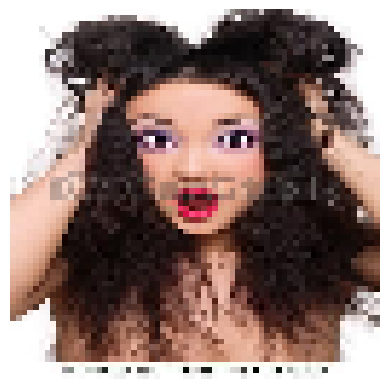

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted class: neutral


In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define class labels dictionary
class_labels = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

# Function to preprocess a single image
def preprocess_image(image_path, target_size=(32, 32)):
    # Load the image with the specified target size
    img = load_img(image_path, target_size=target_size)

    # Display the image (optional, for visualizing what you're testing)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Convert the image to an array
    img_array = img_to_array(img)

    # Normalize the pixel values (same as during training)
    img_array = img_array / 255.0

    # Reshape to fit the model input shape (1, 64, 64, 3)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Function to predict the class of a given image
def predict_image_class(model, image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path, target_size=(64, 64))

    # Make predictions
    predictions = model.predict(processed_image)

    # Get the index of the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Map the predicted class index to the corresponding class label
    predicted_label = class_labels[predicted_class]

    return predicted_label

# Example usage
test_image_path = "/kaggle/input/origin-expw/origin/afraid_asian_153.jpg"  # Replace with your image path
predicted_label = predict_image_class(model, test_image_path)
print(f"Predicted class: {predicted_label}")


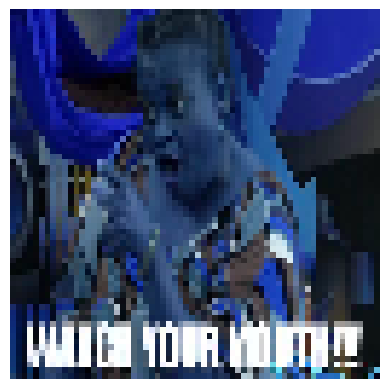

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted class: surprise


In [49]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define class labels dictionary
class_labels = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'sad',
    5: 'surprise',
    6: 'neutral'
}

# Function to preprocess a single image
def preprocess_image(image_path, target_size=(64, 64)):
    # Load the image with the specified target size
    img = load_img(image_path, target_size=target_size)

    # Convert the image to an array
    img_array = img_to_array(img)

    # Convert from BGR to RGB if needed (use this if you're using OpenCV to read images)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    # Display the image (optional, for visualizing what you're testing)
    plt.imshow(img_array.astype(np.uint8))
    plt.axis('off')
    plt.show()

    # Normalize the pixel values (same as during training)
    img_array = img_array / 255.0

    # Reshape to fit the model input shape (1, 64, 64, 3)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Function to predict the class of a given image
def predict_image_class(model, image_path):
    # Preprocess the image
    processed_image = preprocess_image(image_path, target_size=(64, 64))

    # Make predictions
    predictions = model.predict(processed_image)

    # Get the index of the class with the highest probability
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Map the predicted class index to the corresponding class label
    predicted_label = class_labels[predicted_class]

    return predicted_label

# Example usage
test_image_path = "/kaggle/input/origin-expw/origin/afraid_grandmother_695.jpg"  # Replace with your image path
predicted_label = predict_image_class(model, test_image_path)
print(f"Predicted class: {predicted_label}")
